In [1]:
# Seguro.pynb - Data visualisation and analysis of Porto Seguro’s 
#               Safe Driver Prediction dataset

# Objective   - Predict whether or not individuals will claim on their
#               car insurance within one year.

# Data source - 'https://www.kaggle.com/c/porto-seguro-safe-driver-prediction'

# Author      - Adil Khan

In [2]:
#TO DO:

# Strip down unneccessary featuresDistinguish ordinal features from numerical features and research methods to deal with them.
# Undersampling/Oversampling
# Review techniques for 'rare events'
# Further analyse FPR, TPR, Power, etc.
# Further implementation of Bayesian analysis and MCMC
# Investigate why Naive Bayes has a higher ROC AUC but lower score than rest
# Investigate bug in 'Assign lables, Split data into Training and Testing sets'
# Interactions between important features

In [3]:
import os
import time
import random
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, ensemble, naive_bayes
from sklearn.metrics import roc_curve, auc

/Users/Adil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
start=time.time()
path = '/Users/Adil/Documents/Data Science/Competitions/Seguro'
os.chdir(path)
df=pd.read_csv('train.csv').sample(frac=1)

<h1>Data Visualisation</h1>

In [5]:
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
434114,1084757,0,1,1,4,0,0,1,0,0,...,4,2,3,5,0,1,1,0,0,1
536959,1341981,0,0,1,9,0,0,0,0,0,...,4,3,1,9,0,1,1,1,0,1
387253,967668,0,4,2,2,1,0,0,1,0,...,2,0,5,9,0,0,0,1,0,0
163121,407820,0,0,1,6,0,0,0,1,0,...,5,4,5,13,0,0,0,0,0,0
498555,1245929,0,1,1,3,1,0,0,1,0,...,8,1,0,8,0,1,1,0,1,0


In [6]:
df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h2>Monte Carlo Markov Chain</h2>

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p_interval__]
100%|██████████| 10500/10500 [00:20<00:00, 501.14it/s]
The number of effective samples is smaller than 10% for some parameters.


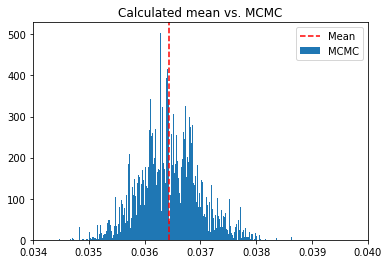

((0.034, 0.04),
 Text(0.5,1,'Calculated mean vs. MCMC'),
 None)

In [7]:
ob=np.asarray(df['target'].sample(frac=0.2)) #Error occurs when frac>0.2. Why?
with pm.Model() as model:
    p=pm.Uniform('p', 0,1, testval=0.5)
    obs = pm.Bernoulli('obs', p , observed=ob)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    burned_trace = trace[1000:]
plt.hist(burned_trace['p'],bins=250, label='MCMC')
plt.axvline(x=ob.mean(),color='r',ls='--',label='Mean')
plt.xlim(0.034,0.04),plt.legend(),plt.title('Calculated mean vs. MCMC'),plt.show()

##  Missing Values

###  Missing Values Identification

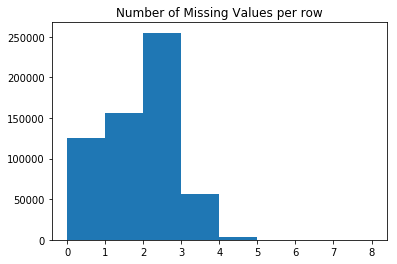

,y=0,y=1,sum
ps_car_03_cat,396124,15107,411231
ps_car_05_cat,256842,9709,266551
ps_reg_03,103822,3950,107772
ps_car_14,41072,1548,42620
ps_car_07_cat,11095,394,11489
ps_ind_05_cat,5615,194,5809
ps_car_09_cat,545,24,569
ps_ind_02_cat,204,12,216
ps_car_01_cat,101,6,107
ps_ind_04_cat,80,3,83


In [8]:
# Replace '-1' with NaN

for i in df.columns:
    df[i]=df[i].replace(-1,np.nan)
    
# Create histogram of missing values per row

row_nan = df.isnull().sum(axis=1)
plt.hist(row_nan, bins=row_nan.max())
plt.title('Number of Missing Values per row')
plt.show()

# Group by target

g=df.groupby(df['target']).groups
indx_0, indx_1 = g[0], g[1]
s_0, s_1 = df.iloc[indx_0] , df.iloc[indx_1] 

# Count NaN in y=0 and y=1

df_0 = pd.DataFrame({'y=0':s_0.isnull().sum()})
df_1 = pd.DataFrame({'y=1':s_1.isnull().sum()})

# Concatenate, add 'Total' column, filter and sort

df_ = pd.concat([df_0,df_1],axis=1)
df_['sum']=df_['y=0']+df_['y=1']
df_[df_['sum']>0].sort_values(by=['sum'],ascending=False)



### Delete Columns and rows with missin data

In [9]:
#  Delete columns with more than 1000 missing values

del_list = df_[df_['sum']>1000].sort_values(by=['sum'],ascending=False).index
new_list = list(set(df.columns)-set(del_list))
df=df[new_list]

#  Remove rows with any missing values. 

df=df.dropna()

print('Number of Missing Values:\t', df.isnull().sum().sum() )

Number of Missing Values:	 0


<h2>Feature Allocation</h2>
<p> Include target with binary variables for now.</p>
<p> Lump ordinal and nominal features together as categorical </p>

In [10]:
binList=[i for i in df.columns if 'bin' in i or 'target' in i]
catList=[i for i in df.columns if 'cat'  in i or 'car' in i]
numList=[i for i in df.columns if 'bin' not in i and 'cat' not in i and 'car' not in i and 'id' not in i and 'target' not in i]

<h2>Correlation Matrix</h2>
<p>
    Spase correlation matrix indicates that most variables are independent. 
</p>

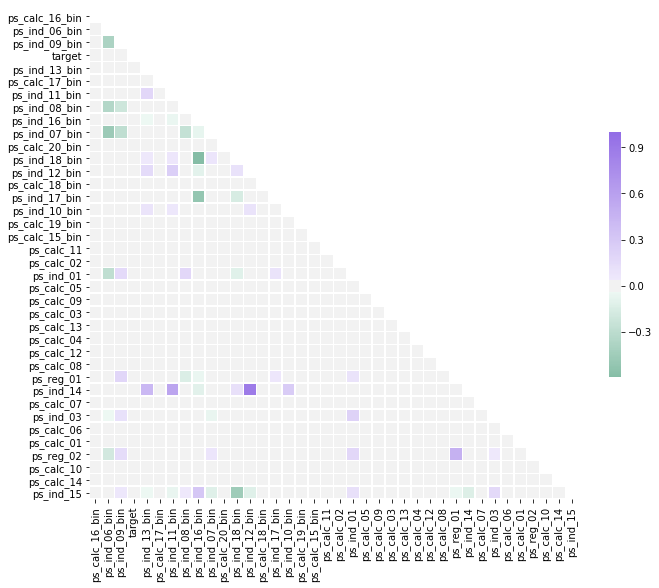

In [11]:
corr=df[binList+numList].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=50, as_cmap=True )

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h2>Feature-Label Correlations</h2>
<p>
    Very low correlation between labels and target, all less than ±0.06. Indicates that numerical features will have poor predictive power.
</p>

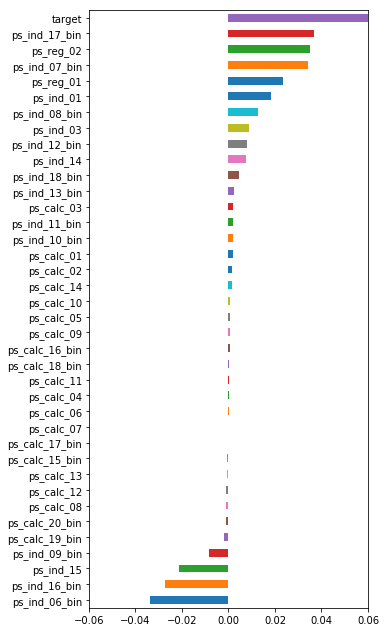

In [12]:
corr.loc['target'].sort_values().plot.barh(figsize=(5,11),xlim=(-0.06,0.06))

<h2>Binaries Feature Proportion of 1's</h2>
<p>
    'ps_ind_10_bin' and 'ps_ind_13_bin' and 'ps_ind_11_bin' are mostly zeros. Infrequently used features could be dropped.
</p>

In [13]:
pd.DataFrame({"Proportion of 1's":df[binList].mean()}).sort_values(by=["Proportion of 1's"])

,Proportion of 1's
ps_ind_10_bin,0.000373
ps_ind_13_bin,0.000942
ps_ind_11_bin,0.001691
ps_ind_12_bin,0.009429
target,0.036373
ps_ind_17_bin,0.121051
ps_calc_15_bin,0.122451
ps_calc_20_bin,0.153335
ps_ind_18_bin,0.153475
ps_ind_08_bin,0.163869


<h2>Distribution of Numerical Values</h2>
<p>Figures below reveal distribution of values in numerical features.</p>
<p>'ps_ind_14' and 'ps_car_14' are dominated by a single value so are not very useful. In 'ps_calc_01', 'ps_calc_02' and 'ps_calc_03' all values are equally likely. 
</p>

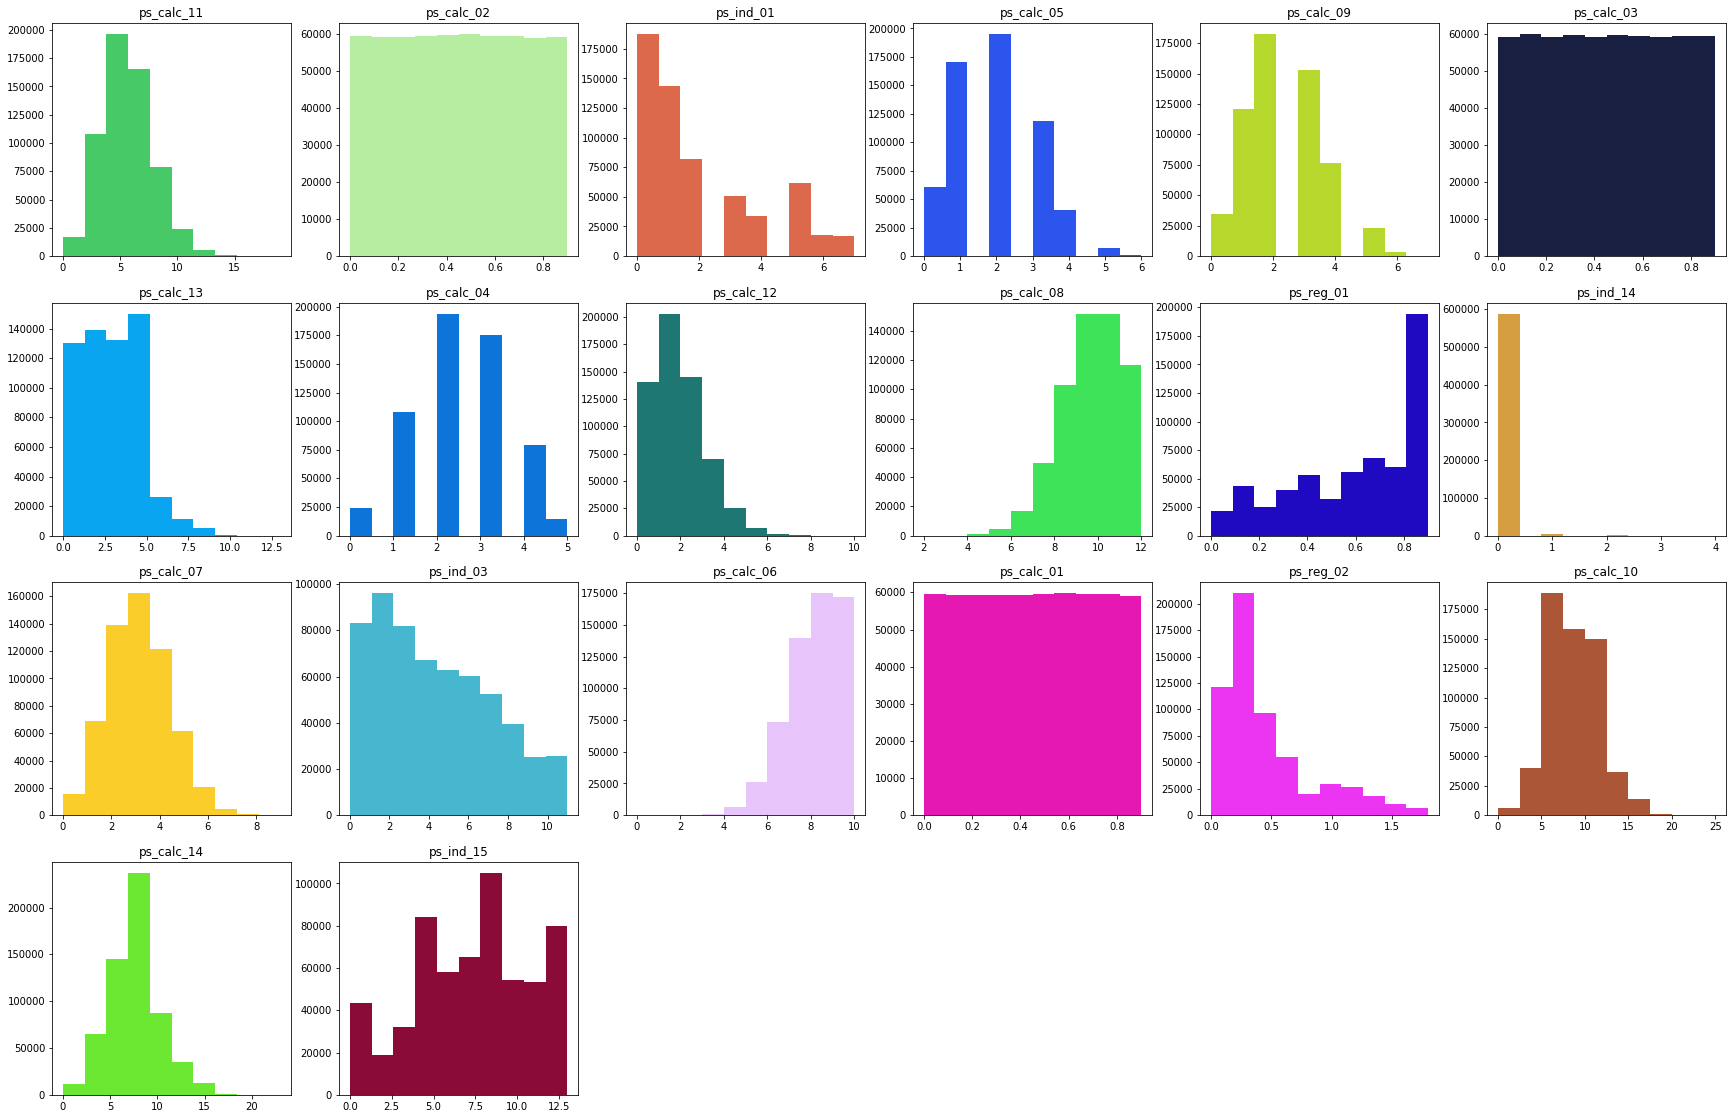

In [ ]:
plt.clf()
plt.figure(figsize=(30,30))
for i,k in enumerate(numList):
    plt.subplot(6,6,i+1),plt.title(k)
    plt.hist(df[k],color=(random.random(),random.random(),random.random()))

# Prepare data for analysis

## One-hot coding 

In [ ]:
catDummyList = []
for i in catList:
    catDummyList.append([])
    i_length = len(df[i].unique())
    catDummyList[-1]=[i+'_dummy_%d' %j for j in range(i_length)]

dummies = pd.DataFrame()
for i,j in enumerate(catList):
    x=pd.get_dummies(df[j])
    x.columns = catDummyList[i]
    dummies=pd.concat([dummies, x], axis=1)

## Normalize Numerical Data

In [ ]:
num_mean =df[numList].mean()
num_std =df[numList].std()
for i,k in enumerate(numList):
    df[k]=(df[k]-num_mean[i])/num_std[i]

## Create Interaction Variables

### Numerical features

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
num2 = poly.fit_transform(df[numList])
dfnum2 = pd.DataFrame(num2, index=df.index, columns=poly.get_feature_names(numList))

### Binary features

In [ ]:
try: binList.remove('target')
except: ValueError
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
bin2 = poly.fit_transform(df[binList])
dfbin2 = pd.DataFrame(bin2,index=df.index, columns=poly.get_feature_names(binList))

### Categorical features
Kernel died as a result of feature explosion. 162 dummy variables yield 13365 interaction variables.

In [ ]:
# poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
# dum2 = poly.fit_transform(dummies)
# dfdum2 = pd.DataFrame(dum2,index=df.index, columns=poly.get_feature_names(catDummyList))

## Stack
Stack 656 features (324 numerical interactions, 170 binary interactions, 162 categorical dummies)

In [ ]:
stacked=pd.concat([dfnum2,dfbin2,dummies],axis=1)

## Assign lables, Split data into Training and Testing sets

In [ ]:
yList = np.asarray(df['target'])
xList=np.asarray(stacked)

xListTrain = [xList[i] for i in range(len(xList)) if i%5!=0]
xListTest = [xList[i] for i in range(len(xList)) if i%5==0]
yListTrain = [yList[i] for i in range(len(yList)) if i%5!=0]
yListTest = [yList[i] for i in range(len(yList)) if i%5==0]

<h1>Models</h1>

<h2>Random Forest Classifier</h2>

In [ ]:
model = ensemble.RandomForestClassifier(n_estimators=250,max_depth=3)
model.fit(xListTrain,yListTrain)
print('Train Score:\t', model.score(xListTrain,yListTrain))
print('Test Score:\t', model.score(xListTest,yListTest))

#ROC

inpred=model.predict(xListTrain)
fpr,tpr, thresholds = roc_curve(yListTrain,inpred)
print('Train ROC:\t', auc(fpr,tpr))
outpred=model.predict(xListTest)
fpr,tpr, thresholds = roc_curve(yListTest,outpred)
print('Test ROC:\t', auc(fpr,tpr))

<h2>Gradient Boosting</h2>

In [ ]:
model = ensemble.GradientBoostingClassifier(n_estimators=20,max_depth=2)
model.fit(xListTrain,yListTrain)
print('Train Score:\t', model.score(xListTrain,yListTrain))
print('Test Score:\t', model.score(xListTest,yListTest))

#ROC

inpred=model.predict(xListTrain)
fpr,tpr, thresholds = roc_curve(yListTrain,inpred)
print('Train ROC:\t', auc(fpr,tpr))
outpred=model.predict(xListTest)
fpr,tpr, thresholds = roc_curve(yListTest,outpred)
print('Test ROC:\t', auc(fpr,tpr))

<h2>Logistic Regression</h1>

In [ ]:
model = linear_model.LogisticRegression()
model.fit(xListTrain,yListTrain)
print('Train score:\t', model.score(xListTrain,yListTrain))
print('Test score:\t', model.score(xListTest,yListTest))

#ROC

inpred=model.predict(xListTrain)
fpr,tpr, thresholds = roc_curve(yListTrain,inpred)
print('Train ROC:\t', auc(fpr,tpr))
outpred=model.predict(xListTest)
fpr,tpr, thresholds = roc_curve(yListTest,outpred)
print('Test ROC:\t', auc(fpr,tpr))

<h2>Naive Bayes</h2>

In [ ]:
model = naive_bayes.GaussianNB()
model.fit(xListTrain,yListTrain)
print('Train score:\t', model.score(xListTrain,yListTrain))
print('Test score:\t', model.score(xListTest,yListTest))

#ROC

inpred=model.predict(xListTrain)
fpr,tpr, thresholds = roc_curve(yListTrain,inpred)
print('Train ROC:\t', auc(fpr,tpr))
outpred=model.predict(xListTest)
fpr,tpr, thresholds = roc_curve(yListTest,outpred)
print('Test ROC:\t', auc(fpr,tpr))

<h2>Stochastic Gradient Descent</h2>

In [ ]:
model = linear_model.SGDClassifier()
model.fit(xListTrain,yListTrain)
print('Train score:\t', model.score(xListTrain,yListTrain))
print('Test score:\t', model.score(xListTest,yListTest))

#ROC

inpred=model.predict(xListTrain)
fpr,tpr, thresholds = roc_curve(yListTrain,inpred)
print('Train ROC:\t', auc(fpr,tpr))
outpred=model.predict(xListTest)
fpr,tpr, thresholds = roc_curve(yListTest,outpred)
print('Test ROC:\t', auc(fpr,tpr))

In [ ]:
t=time.time()-start
print('Time taken:\t%d minutes %d seconds' % ((t//60),(t%60)) )